# Adding libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library


from bs4 import BeautifulSoup

print('Libraries imported.')



Libraries imported.


## Importing CSV


In [2]:
Germany = pd.read_csv('germany.csv')
Germany.sort_values(by = 'population', ascending = False)
Germany.drop(columns = ['country', 'city_ascii','iso2', 'iso3', 'admin_name', 'capital', 'id'], inplace = True)
Germany.head()



,city,lat,lng,population
0,Berlin,"52,5218","13,4015",3406000
1,Stuttgart,"48,78","9,2",2944700
2,Frankfurt,"50,1","8,675",2895000
3,Mannheim,"49,5004","8,47",2362000
4,Hamburg,"53,55",10,1757000


In [3]:
Germany = Germany.rename(columns = {'lat':'Latitude', 'lng': 'Longitude', 'city': 'City'})
Germany.head()



,City,Latitude,Longitude,population
0,Berlin,"52,5218","13,4015",3406000
1,Stuttgart,"48,78","9,2",2944700
2,Frankfurt,"50,1","8,675",2895000
3,Mannheim,"49,5004","8,47",2362000
4,Hamburg,"53,55",10,1757000


In [4]:
Germany_clean=Germany.drop(columns= ['population'])
Germany_clean.head()
Germany_clean['Latitude']=Germany_clean['Latitude'].apply(lambda x: x.replace(',','.'))
Germany_clean['Longitude']=Germany_clean['Longitude'].apply(lambda x: x.replace(',','.'))
Germany_clean[['Latitude','Longitude']]=Germany_clean[['Latitude','Longitude']].astype('float')
Germany_clean.dtypes

City          object
Latitude     float64
Longitude    float64
dtype: object

In [5]:
address = 'Germany'

geolocator = Nominatim(user_agent="germany")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Germany are {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Germany are 51.0834196, 10.4234469.


## Creating map of Germany

In [6]:
map_germany = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, city in zip(Germany_clean['Latitude'], Germany_clean['Longitude'], Germany_clean['City']):
    label = ' {}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_germany)

map_germany

## Using Foursquare

In [7]:
CLIENT_ID = 'XEO5A5ZBI0P3HE4W0JPTS3UJCMQTP4WU5ZCNZHUB4ATFSV1B' # your Foursquare ID
CLIENT_SECRET = 'OT111S4TFMPLV2X1JJD1QRFO0CT3ZLXHCEB25OQ0ZH5ARIXW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: XEO5A5ZBI0P3HE4W0JPTS3UJCMQTP4WU5ZCNZHUB4ATFSV1B
CLIENT_SECRET:OT111S4TFMPLV2X1JJD1QRFO0CT3ZLXHCEB25OQ0ZH5ARIXW


In [8]:
#Function to apply it to every Postcode we have.
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'City Latitude',
                  'City Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)



In [9]:
germany_venues = getNearbyVenues(names=Germany_clean['City'],
                                   latitudes=Germany_clean['Latitude'],
                                   longitudes=Germany_clean['Longitude']
                                  )


Berlin
Stuttgart
Frankfurt
Mannheim
Hamburg
Essen
Duisburg
Munich
Düsseldorf
Cologne
Wuppertal
Saarbrücken
Nuremberg
Bremen
Hannover
Bonn
Dresden
Wiesbaden
Dortmund
Leipzig
Heidelberg
Karlsruhe
Augsburg
Bielefeld
Koblenz
Chemnitz
Kassel
Münster
Kiel
Freiburg im Breisgau
Braunschweig
Fürth
Lübeck
Osnabrück
Magdeburg
Potsdam
Erfurt
Rostock
Mainz
Ulm
Würzburg
Oldenburg
Regensburg
Ingolstadt
Göttingen
Bremerhaven
Cottbus
Jena
Gera
Schwerin
Flensburg
Rosenheim
Gießen
Stralsund
Coburg
Hof
Emden
Passau


In [10]:
print(germany_venues.shape)
germany_venues.head()



(1121, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.5218,13.4015,Buchhandlung Walther König,52.521301,13.400758,Bookstore
1,Berlin,52.5218,13.4015,James-Simon-Park,52.521907,13.399361,Park
2,Berlin,52.5218,13.4015,Café 93,52.522997,13.399752,Café
3,Berlin,52.5218,13.4015,Hotel ZOE,52.523095,13.400966,Hotel
4,Berlin,52.5218,13.4015,MA'LOA Poké Bowl,52.523653,13.400399,Poke Place


In [11]:
#Grouping by Neighborhood will be necessarily, and also more readable.
germany_venues.groupby('City').count().head()


,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Augsburg,5,5,5,5,5,5
Berlin,100,100,100,100,100,100
Bielefeld,26,26,26,26,26,26
Bonn,4,4,4,4,4,4
Bremen,26,26,26,26,26,26


In [12]:
print('There are {} uniques categories.'.format(len(germany_venues['Venue Category'].unique())))


There are 213 uniques categories.


In [13]:
# one hot encoding
germany_onehot = pd.get_dummies(germany_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
germany_onehot['City'] = germany_venues['City']

# move neighborhood column to the first column
fixed_columns = [germany_onehot.columns[-1]] + list(germany_onehot.columns[:-1])
germany_onehot = germany_onehot[fixed_columns]
germany_onehot.head()


,City,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Food & Drink Shop,Fountain,Franconian Restaurant,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pharmacy,Pide Place,Pier,Pizza Place,Platform,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berlin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
germany_onehot.shape

(1121, 214)

In [15]:
#Here we are showing the mean of what each neighborhood has close by
germany_grouped = germany_onehot.groupby('City').mean().reset_index()
germany_grouped.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bakery,Bank,Bar,Bavarian Restaurant,Beach,Beach Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Currywurst Joint,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flea Market,Food & Drink Shop,Fountain,Franconian Restaurant,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Manti Place,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Outlet Store,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pharmacy,Pide Place,Pier,Pizza Place,Platform,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Record Shop,Restaurant,River,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Smoothie Shop,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tech Startup,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Augsburg,0.0,0.00,0.0,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.2,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.200000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.20,0.0,0.000000,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0
1,Berlin,0.0,0.01,0.0,0.000000

In [16]:
germany_grouped.shape



(56, 214)

In [17]:
#Now, we are going to show what has more frequency in each of those neighborhoods.
num_top_venues = 5

for hood in germany_grouped['City']:
    print("----"+hood+"----")
    temp = germany_grouped[germany_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Augsburg----
                venue  freq
0          Steakhouse   0.2
1         Bus Station   0.2
2  Light Rail Station   0.2
3              Museum   0.2
4               Hotel   0.2


----Berlin----
            venue  freq
0     Art Gallery  0.06
1           Hotel  0.05
2  Clothing Store  0.05
3  Ice Cream Shop  0.05
4  History Museum  0.04


----Bielefeld----
              venue  freq
0       Supermarket  0.15
1         Nightclub  0.12
2  Asian Restaurant  0.08
3             Hotel  0.08
4               Bar  0.08


----Bonn----
               venue  freq
0           Bus Stop  0.25
1       Intersection  0.25
2  Indian Restaurant  0.25
3       Tech Startup  0.25
4  Accessories Store  0.00


----Bremen----
                venue  freq
0               Hotel  0.15
1              Bakery  0.08
2  Italian Restaurant  0.04
3         Salad Place  0.04
4           Drugstore  0.04


----Bremerhaven----
                venue  freq
0           Drugstore  0.33
1                Café  0.33
2         

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]


In [19]:
#And add it into a pandas dataframe to be able to apply afterwards Kclustering.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_sorted = pd.DataFrame(columns=columns)
cities_sorted['City'] = germany_grouped['City']

for ind in np.arange(germany_grouped.shape[0]):
    cities_sorted.iloc[ind, 1:] = return_most_common_venues(germany_grouped.iloc[ind, :], num_top_venues)

cities_sorted.head()



,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Augsburg,Steakhouse,Museum,Bus Station,Hotel,Light Rail Station,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store
1,Berlin,Art Gallery,Hotel,Clothing Store,Ice Cream Shop,Café,Coffee Shop,History Museum,Art Museum,Park,Indie Movie Theater
2,Bielefeld,Supermarket,Nightclub,Bar,Hotel,Asian Restaurant,Italian Restaurant,German Restaurant,Middle Eastern Restaurant,Greek Restaurant,Metro Station
3,Bonn,Intersection,Indian Restaurant,Bus Stop,Tech Startup,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
4,Bremen,Hotel,Bakery,Italian Restaurant,Sushi Restaurant,Pedestrian Plaza,Fast Food Restaurant,Cosmetics Shop,Salad Place,Nightclub,Cocktail Bar


In [20]:
# set number of clusters, in this case we choose 3 clusters because if its >3 we will have clusters with only one data in it.
kclusters = 4

germany_grouped_clustering = germany_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(germany_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [21]:
# add clustering labels
cities_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

germany_merged = Germany_clean

# merge netherlands_merged with cities_sorted to add latitude/longitude for each neighborhood
germany_merged = germany_merged.join(cities_sorted.set_index('City'), on='City')

germany_merged.head() # check the last columns!



,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,52.5218,13.4015,1.0,Art Gallery,Hotel,Clothing Store,Ice Cream Shop,Café,Coffee Shop,History Museum,Art Museum,Park,Indie Movie Theater
1,Stuttgart,48.7800,9.2000,1.0,Indian Restaurant,Bus Stop,Café,Mini Golf,Scenic Lookout,Zoo,Financial or Legal Service,Garden,Furniture / Home Store,Frozen Yogurt Shop
2,Frankfurt,50.1000,8.6750,1.0,Café,Bar,Bakery,Italian Restaurant,Drugstore,Park,Art Museum,Restaurant,Supermarket,Greek Restaurant
3,Mannheim,49.5004,8.4700,1.0,Café,Food & Drink Shop,Greek Restaurant,Plaza,Grocery Store,Music Venue,Light Rail Station,Turkish Restaurant,Trattoria/Osteria,Mediterranean Restaurant
4,Hamburg,53.5500,10.0000,1.0,Coffee Shop,Hotel,Vietnamese Restaurant,Cosmetics Shop,Burger Joint,Café,Clothing Store,German Restaurant,Restaurant,Cocktail Bar


In [22]:
cities_sorted.head()


,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Augsburg,Steakhouse,Museum,Bus Station,Hotel,Light Rail Station,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store
1,1,Berlin,Art Gallery,Hotel,Clothing Store,Ice Cream Shop,Café,Coffee Shop,History Museum,Art Museum,Park,Indie Movie Theater
2,1,Bielefeld,Supermarket,Nightclub,Bar,Hotel,Asian Restaurant,Italian Restaurant,German Restaurant,Middle Eastern Restaurant,Greek Restaurant,Metro Station
3,1,Bonn,Intersection,Indian Restaurant,Bus Stop,Tech Startup,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
4,1,Bremen,Hotel,Bakery,Italian Restaurant,Sushi Restaurant,Pedestrian Plaza,Fast Food Restaurant,Cosmetics Shop,Salad Place,Nightclub,Cocktail Bar


In [23]:
#Deletint the NaN Cluster Labels and making them int for ploting purposes in the future.
cities_sorted.shape
cities_sorted = cities_sorted.dropna(axis='rows')
cities_sorted['Cluster Labels'] = cities_sorted['Cluster Labels'].astype(int)
cities_sorted.head()

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Augsburg,Steakhouse,Museum,Bus Station,Hotel,Light Rail Station,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store
1,1,Berlin,Art Gallery,Hotel,Clothing Store,Ice Cream Shop,Café,Coffee Shop,History Museum,Art Museum,Park,Indie Movie Theater
2,1,Bielefeld,Supermarket,Nightclub,Bar,Hotel,Asian Restaurant,Italian Restaurant,German Restaurant,Middle Eastern Restaurant,Greek Restaurant,Metro Station
3,1,Bonn,Intersection,Indian Restaurant,Bus Stop,Tech Startup,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
4,1,Bremen,Hotel,Bakery,Italian Restaurant,Sushi Restaurant,Pedestrian Plaza,Fast Food Restaurant,Cosmetics Shop,Salad Place,Nightclub,Cocktail Bar


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(germany_merged['Latitude'], germany_merged['Longitude'], germany_merged['City'], cities_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
#Cluster 0
germany_merged.loc[germany_merged['Cluster Labels'] == 0, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Saarbrücken,Supermarket,Light Rail Station,Chinese Restaurant,Bakery,Shopping Mall,Zoo,Flea Market,Garden Center,Garden,Furniture / Home Store
18,Dortmund,Supermarket,Indie Theater,Mediterranean Restaurant,Flea Market,Bar,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
40,Würzburg,Supermarket,Fast Food Restaurant,Bakery,Diner,Hotel,Gym / Fitness Center,Big Box Store,Park,Nightclub,Asian Restaurant
41,Oldenburg,Supermarket,Bavarian Restaurant,Doner Restaurant,Greek Restaurant,Bakery,Flea Market,Gas Station,Garden Center,Garden,Furniture / Home Store
46,Cottbus,Shoe Store,Supermarket,Plaza,Fast Food Restaurant,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Franconian Restaurant
53,Stralsund,Gas Station,Supermarket,Harbor / Marina,Fast Food Restaurant,Zoo,Flea Market,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop
54,Coburg,Supermarket,Hotel,Multiplex,Thai Restaurant,Financial or Legal Service,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop


In [26]:

#Cluster 1
germany_merged.loc[germany_merged['Cluster Labels'] == 1, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,Art Gallery,Hotel,Clothing Store,Ice Cream Shop,Café,Coffee Shop,History Museum,Art Museum,Park,Indie Movie Theater
1,Stuttgart,Indian Restaurant,Bus Stop,Café,Mini Golf,Scenic Lookout,Zoo,Financial or Legal Service,Garden,Furniture / Home Store,Frozen Yogurt Shop
2,Frankfurt,Café,Bar,Bakery,Italian Restaurant,Drugstore,Park,Art Museum,Restaurant,Supermarket,Greek Restaurant
3,Mannheim,Café,Food & Drink Shop,Greek Restaurant,Plaza,Grocery Store,Music Venue,Light Rail Station,Turkish Restaurant,Trattoria/Osteria,Mediterranean Restaurant
4,Hamburg,Coffee Shop,Hotel,Vietnamese Restaurant,Cosmetics Shop,Burger Joint,Café,Clothing Store,German Restaurant,Restaurant,Cocktail Bar
5,Essen,Hotel,Bakery,Cocktail Bar,Drugstore,Italian Restaurant,Clothing Store,Coffee Shop,Seafood Restaurant,Cosmetics Shop,Dim Sum Restaurant
6,Duisburg,Italian Restaurant,Turkish Restaurant,Theater,Bar,Doner Restaurant,Financial or Legal Service,Gas Station,Garden Center,Garden,Furniture / Home Store
7,Munich,Café,Cocktail Bar,Bar,Supermarket,Pizza Place,Asian Restaurant,Breakfast Spot,Afghan Restaurant,Vietnamese Restaurant,Coffee Shop
8,Düsseldorf,Café,Boutique,Italian Restaurant,Coffee Shop,Plaza,Vegetarian / Vegan Restaurant,Furniture / Home Store,Drugstore,Steakhouse,Souvlaki Shop
9,Cologne,Hotel,Pub,Café,Sushi Restaurant,Event Space,Indian Restaurant,German Restaurant,Gym / Fitness Center,Lounge,Restaurant


In [27]:
#Cluster 2
germany_merged.loc[germany_merged['Cluster Labels'] == 2, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Wuppertal,Pool,German Restaurant,Café,Sculpture Garden,Zoo,Financial or Legal Service,Garden,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant
44,Göttingen,German Restaurant,Lake,Financial or Legal Service,Gastropub,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant


In [28]:

#Cluster 3
germany_merged.loc[germany_merged['Cluster Labels'] == 3, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Freiburg im Breisgau,Hotel,Zoo,Fast Food Restaurant,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Franconian Restaurant
56,Emden,Hotel,Steakhouse,Hostel,Fast Food Restaurant,Gas Station,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant


Text(0, 0.5, 'Frequency')

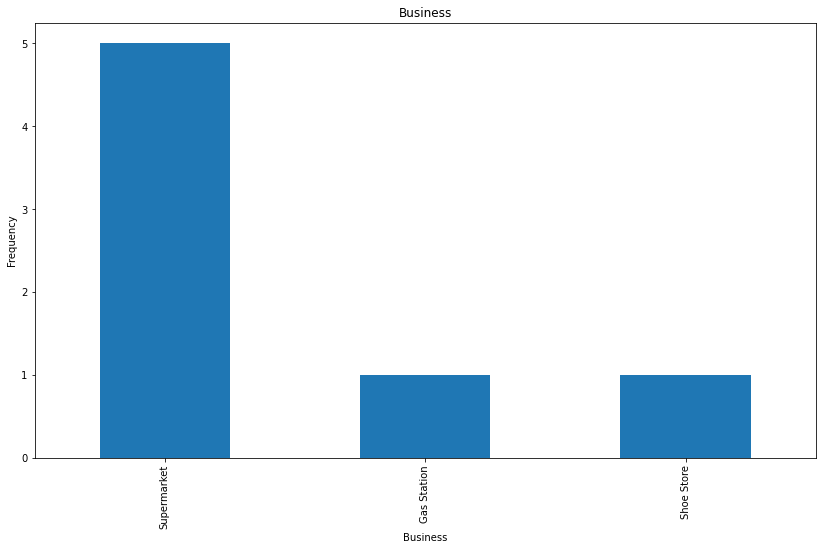

In [29]:
# Graph Cluster 0
Germany_dsn=germany_merged.loc[germany_merged['Cluster Labels'] == 0, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]
dfl=Germany_dsn.drop(['City'], axis=1)
top1=dfl['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Business")
top1.set_xlabel("Business")
top1.set_ylabel("Frequency")

Text(17.200000000000017, 0.5, 'Frequency')

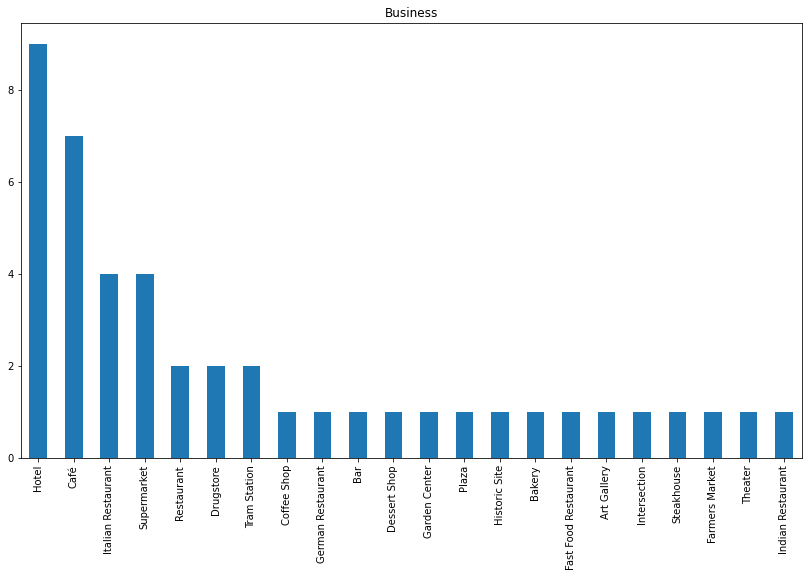

In [30]:
# Graph Cluster 1
Germany_dsn2=germany_merged.loc[germany_merged['Cluster Labels'] == 1, germany_merged.columns[[0] + list(range(4, germany_merged.shape[1]))]]
dfl2=Germany_dsn2.drop(['City'], axis=1)
top2=dfl2['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Business")
top1.set_xlabel("Business")
top1.set_ylabel("Frequency")
